In [2]:
from sklearn import model_selection, preprocessing, metrics, linear_model, svm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from imblearn.over_sampling import BorderlineSMOTE, SMOTE, ADASYN, SMOTENC, RandomOverSampler
from imblearn.under_sampling import (RandomUnderSampler, 
                                    NearMiss, 
                                    InstanceHardnessThreshold,
                                    CondensedNearestNeighbour,
                                    EditedNearestNeighbours,
                                    RepeatedEditedNearestNeighbours,
                                    AllKNN,
                                    NeighbourhoodCleaningRule,
                                    OneSidedSelection,
                                    TomekLinks)
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.pipeline import make_pipeline
import pandas as pd, numpy, string
from nltk.tokenize import WordPunctTokenizer
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup

In [3]:
#Remove Special Charactors
import re
from nltk.tokenize import WordPunctTokenizer
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup


#pipeline
from numpy import where
from matplotlib import pyplot

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

#Resampling_Pipeline function
from imblearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from sklearn.ensemble import RandomForestClassifier as RF

In [7]:

import numpy as np
import pandas as pd
import math
from sklearn.model_selection import train_test_split


#Import Training and Testing Data
train = pd.read_csv('hate_dataset.csv')
print("Training Set:"% train.columns, train.shape, len(train))

Training Set: (31962, 3) 31962


In [8]:
porter=PorterStemmer()
tok = WordPunctTokenizer()
pat1 = r'@[A-Za-z0-9]+'
pat2 = r'https?://[A-Za-z0-9./]+'
combined_pat = r'|'.join((pat1, pat2))
def tweet_cleaner(text):
    soup = BeautifulSoup(text, 'lxml')
    souped = soup.get_text()
    stripped = re.sub(combined_pat, '', souped)
    try:
        clean = stripped.decode("utf-8-sig").replace(u"\ufffd", "?")
    except:
        clean = stripped
    letters_only = re.sub("[^a-zA-Z]", " ", clean)
    lower_case = letters_only.lower()
    # During the letters_only process two lines above, it has created unnecessay white spaces,
    # I will tokenize and join together to remove unneccessary white spaces
    words = tok.tokenize(lower_case)
    #Stemming
    stem_sentence=[]
    for word in words:
        stem_sentence.append(porter.stem(word))
        stem_sentence.append(" ")
    words="".join(stem_sentence).strip()
    return words

nums = [0,len(train)]
clean_tweet_texts = []
for i in range(nums[0],nums[1]):
    clean_tweet_texts.append(tweet_cleaner(train['tweet'][i]))

    
train_clean = pd.DataFrame(clean_tweet_texts,columns=['tweet'])
train_clean['label'] = train.label
train_clean['id'] = train.id


In [9]:
#split the dataset into training and validation datasets 
train_x, valid_x, train_y, valid_y = model_selection.train_test_split(train_clean['tweet'],train_clean['label'])

#label encode the target variable 
encoder = preprocessing.LabelEncoder()
train_y = encoder.fit_transform(train_y)
valid_y = encoder.fit_transform(valid_y)

In [10]:
# word level tf-idf
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=100000)
tfidf_vect.fit(train_clean['tweet'])
xtrain_tfidf =  tfidf_vect.transform(train_x)
xvalid_tfidf =  tfidf_vect.transform(valid_x)

In [11]:
#Percentage of Positive/Negative
print("Positive: ", train.label.value_counts()[0]/len(train)*100,"%")
print("Negative: ", train.label.value_counts()[1]/len(train)*100,"%")

print("Positive: ", train.label.value_counts()[0])
print("Negative: ", train.label.value_counts()[1])

Positive:  92.98542018647143 %
Negative:  7.014579813528565 %
Positive:  29720
Negative:  2242


In [12]:
def train_model(classifier, feature_vector_train, label, feature_vector_valid):
    # fit the training dataset on the classifier
    classifier.fit(feature_vector_train, label)
    
    # predict the labels on validation dataset
    predictions = classifier.predict(feature_vector_valid)
    
    return metrics.f1_score(valid_y,predictions)

### **Original model accuracy without resampling**

In [19]:
accuracyORIGINAL_SVM = train_model(svm.LinearSVC(), xtrain_tfidf, train_y, xvalid_tfidf)
print ("SVM Baseline, WordLevel TFIDF: ", accuracyORIGINAL_SVM)
accuracyORIGINAL_RF = train_model(RF(), xtrain_tfidf, train_y, xvalid_tfidf)
print ("RF Baseline, WordLevel TFIDF: ", accuracyORIGINAL_SVM)

SVM Baseline, WordLevel TFIDF:  0.6903225806451612
RF Baseline, WordLevel TFIDF:  0.6903225806451612


In [14]:
def plotData(Data, x, d, xlabel, ylabel, ax, color, lab):
    best_model = max(Data)

    for i in range(0, d):
        if(Data[i] == best_model):
            max_n = i
    
    ax.plot(x, Data, color=color,marker='o', markerfacecolor=color, markersize=8, label=lab)
    ax.plot(x[max_n], best_model, marker='x', markersize=20,  markerfacecolor=color)
    
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)


In [23]:
xtrain_tfidf.shape[1]

(23971, 31427)

In [28]:
def ResamplingPipe(Model):
    score_list_SVM = []
    score_list_RF = []
    score_list_SVM.append(accuracyORIGINAL_SVM)
    score_list_RF.append(accuracyORIGINAL_RF)
    ratios = [0.25,0.5,0.75,1]
    
    for ratio in ratios:
        over = Model(sampling_strategy=ratio, random_state=777)
        steps = [('o', over)]
        pipeline = Pipeline(steps=steps)
        new_xtrain_tfidf, new_train_y = pipeline.fit_resample(xtrain_tfidf, train_y)
      
        
        accuracy_SVM = train_model(svm.LinearSVC(),new_xtrain_tfidf, new_train_y, xvalid_tfidf)
        print ("SVM, WordLevel TFIDF: ", accuracy_SVM)
        score_list_SVM.append(accuracy_SVM)
        
        n_features = new_xtrain_tfidf.shape[1]
        tuned_params = {'n_estimators': [1000], 'max_depth':[None], 'max_features': [math.floor(math.sqrt(n_features))], 'min_samples_split': [2],}
        accuracy_RF = train_model(RF(), new_xtrain_tfidf, new_train_y, xvalid_tfidf)
        print ("RF, WordLevel TFIDF: ", accuracy_SVM)
        score_list_RF.append(accuracy_SVM)
        
    ratios.insert(0, 0.0)
    xlabel = "Oversampling Ratio"
    ylabel = "F1 Score"
    fig, ax = plt.subplots(figsize=(4, 4))
    plotData(score_list_SVM ,ratios, 5, xlabel, ylabel, ax, 'red', lab="Support Vector Machine")
    plotData(score_list_RF ,ratios, 5, xlabel, ylabel, ax, 'blue', lab="Random Forest")
    #ax.set_ylim([0, 1])
    ax.legend(bbox_to_anchor = (1.0, 1), loc = 'lower right')
    
    result_list = [score_list_SVM, score_list_RF]
  
    plt.show()
    
    return result_list

## **Random Over-sampling**

SVM, WordLevel TFIDF:  0.7172675521821632
RF, WordLevel TFIDF:  0.7172675521821632
SVM, WordLevel TFIDF:  0.7097933513027853
RF, WordLevel TFIDF:  0.7097933513027853
SVM, WordLevel TFIDF:  0.7031802120141342
RF, WordLevel TFIDF:  0.7031802120141342
SVM, WordLevel TFIDF:  0.6980802792321117
RF, WordLevel TFIDF:  0.6980802792321117


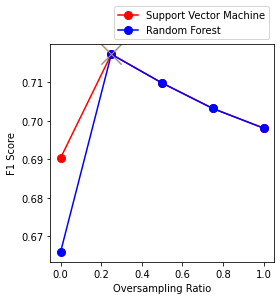

In [29]:
ROS_list = ResamplingPipe(RandomOverSampler)

## **SMOTE Over-sampling**

SVM, WordLevel TFIDF:  0.7260663507109004
RF, WordLevel TFIDF:  0.7260663507109004
SVM, WordLevel TFIDF:  0.7199999999999999
RF, WordLevel TFIDF:  0.7199999999999999
SVM, WordLevel TFIDF:  0.709849157054126
RF, WordLevel TFIDF:  0.709849157054126
SVM, WordLevel TFIDF:  0.7049608355091384
RF, WordLevel TFIDF:  0.7049608355091384


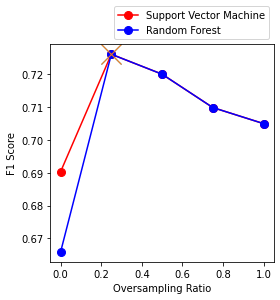

In [30]:
SMOTE_list = ResamplingPipe(SMOTE)

## **ADASYN: Adaptive synthetic sampling (Over-sampling)**

SVM, WordLevel TFIDF:  0.7187206020696142
RF, WordLevel TFIDF:  0.7187206020696142
SVM, WordLevel TFIDF:  0.714795008912656
RF, WordLevel TFIDF:  0.714795008912656
SVM, WordLevel TFIDF:  0.7037358818418766
RF, WordLevel TFIDF:  0.7037358818418766
SVM, WordLevel TFIDF:  0.7012089810017272
RF, WordLevel TFIDF:  0.7012089810017272


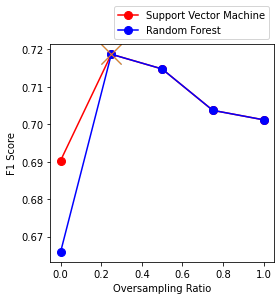

In [31]:
ADASYN_list = ResamplingPipe(ADASYN)

## **Borderline SMOTE¶**

SVM, WordLevel TFIDF:  0.7192307692307692
RF, WordLevel TFIDF:  0.7192307692307692
SVM, WordLevel TFIDF:  0.7087912087912088
RF, WordLevel TFIDF:  0.7087912087912088
SVM, WordLevel TFIDF:  0.7050359712230215
RF, WordLevel TFIDF:  0.7050359712230215
SVM, WordLevel TFIDF:  0.7004444444444444
RF, WordLevel TFIDF:  0.7004444444444444


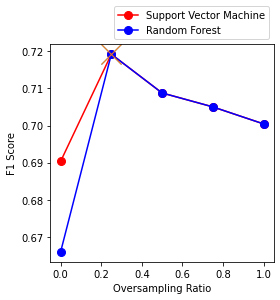

In [32]:
BS_list = ResamplingPipe(BorderlineSMOTE)

**results for SVM**

In [33]:
ROS_list[0]#2

[0.6903225806451612,
 0.7172675521821632,
 0.7097933513027853,
 0.7031802120141342,
 0.6980802792321117]

In [6]:
ROS_list1 = [0.6903225806451612,
 0.7172675521821632,
 0.7097933513027853,
 0.7031802120141342,
 0.6980802792321117]

In [34]:
SMOTE_list[0]#2

[0.6903225806451612,
 0.7260663507109004,
 0.7199999999999999,
 0.709849157054126,
 0.7049608355091384]

In [7]:
SMOTE_list1 = [0.6903225806451612,
 0.7260663507109004,
 0.7199999999999999,
 0.709849157054126,
 0.7049608355091384]

In [35]:
ADASYN_list[0]#2

[0.6903225806451612,
 0.7187206020696142,
 0.714795008912656,
 0.7037358818418766,
 0.7012089810017272]

In [8]:
ADASYN_list1 = [0.6903225806451612,
 0.7187206020696142,
 0.714795008912656,
 0.7037358818418766,
 0.7012089810017272]

In [36]:
BS_list[0]#2

[0.6903225806451612,
 0.7192307692307692,
 0.7087912087912088,
 0.7050359712230215,
 0.7004444444444444]

In [9]:
BS_list1 = [0.6903225806451612,
 0.7192307692307692,
 0.7087912087912088,
 0.7050359712230215,
 0.7004444444444444]

**results for RF**

In [37]:
ROS_list[1]#2

[0.6659142212189617,
 0.7172675521821632,
 0.7097933513027853,
 0.7031802120141342,
 0.6980802792321117]

In [10]:
ROS_list2 = [0.6659142212189617,
 0.7172675521821632,
 0.7097933513027853,
 0.7031802120141342,
 0.6980802792321117]

In [38]:
SMOTE_list[1]#2

[0.6659142212189617,
 0.7260663507109004,
 0.7199999999999999,
 0.709849157054126,
 0.7049608355091384]

In [11]:
SMOTE_list2 = [0.6659142212189617,
 0.7260663507109004,
 0.7199999999999999,
 0.709849157054126,
 0.7049608355091384]

In [39]:
ADASYN_list[1]#2

[0.6659142212189617,
 0.7187206020696142,
 0.714795008912656,
 0.7037358818418766,
 0.7012089810017272]

In [12]:
ADASYN_list2 = [0.6659142212189617,
 0.7187206020696142,
 0.714795008912656,
 0.7037358818418766,
 0.7012089810017272]

In [40]:
BS_list[1]#2

[0.6659142212189617,
 0.7192307692307692,
 0.7087912087912088,
 0.7050359712230215,
 0.7004444444444444]

In [13]:
BS_list2 = [0.6659142212189617,
 0.7192307692307692,
 0.7087912087912088,
 0.7050359712230215,
 0.7004444444444444]

In [ ]:
xlabel = 'Oversampling Ratio'
ylabel = 'F1 Score'
d = 5

ratios = [0.0, 0.25, 0.5, 0.75, 1]
fig, (ax1, ax2) =  plt.subplots(1,2, figsize=(10,8))
plotData(ROS_list[1], ratios, 5, xlabel, ylabel, ax1, color="blue", lab='ROS')
plotData(SMOTE_list[1] ,ratios, 5, xlabel, ylabel, ax1, color="red", lab='SMOTE')
plotData(ADASYN_list[1] ,ratios, 5, xlabel, ylabel, ax1, color="green", lab='ADASYN')
plotData(BS_list[1] ,ratios, 5, xlabel, ylabel, ax1, color="yellow",lab='B-SMOTE')
ax1.set_ylim([0.5, 0.75])
ax1.set_title('Random Forest')
ax1.axhline(y =0.7260663507109004, color = 'blue', linestyle = ':')
    
plotData(ROS_list[0], ratios, 5, xlabel, ylabel, ax2, color="blue",lab='ROS')
plotData(SMOTE_list[0] ,ratios, 5, xlabel, ylabel, ax2, color="red", lab='SMOTE')
plotData(ADASYN_list[0] ,ratios, 5, xlabel, ylabel, ax2, color="green",lab='ADASYN')
plotData(BS_list[0] ,ratios, 5, xlabel, ylabel, ax2, color="yellow", lab='B-SMOTE')
ax2.set_ylim([0.5, 0.75])
ax2.axhline(y =0.7260663507109004, color = 'red', linestyle = ':')
ax2.set_title('Support Vector Machine')
ax2.legend(bbox_to_anchor = (1.0, 1), loc = 'upper right')

plt.show()

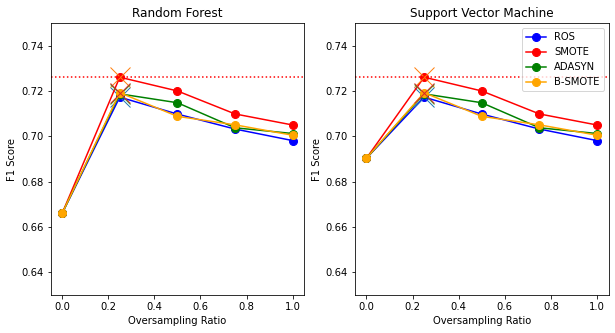

In [28]:
import matplotlib.pyplot as plt
xlabel = 'Oversampling Ratio'
ylabel = 'F1 Score'
d = 5


ratios = [0.0, 0.25, 0.5, 0.75, 1]
fig, (ax1, ax2) =  plt.subplots(1,2, figsize=(10, 5))
plotData(ROS_list2, ratios, 5, xlabel, ylabel, ax1, color="blue", lab='ROS')
plotData(SMOTE_list2 ,ratios, 5, xlabel, ylabel, ax1, color="red", lab='SMOTE')
plotData(ADASYN_list2 ,ratios, 5, xlabel, ylabel, ax1, color="green", lab='ADASYN')
plotData(BS_list2 ,ratios, 5, xlabel, ylabel, ax1, color="orange",lab='B-SMOTE')
ax1.set_ylim([0.63, 0.75])
ax1.set_title('Random Forest')
ax1.axhline(y =0.7260663507109004, color = 'red', linestyle = ':')
    
plotData(ROS_list1, ratios, 5, xlabel, ylabel, ax2, color="blue",lab='ROS')
plotData(SMOTE_list1,ratios, 5, xlabel, ylabel, ax2, color="red", lab='SMOTE')
plotData(ADASYN_list1 ,ratios, 5, xlabel, ylabel, ax2, color="green",lab='ADASYN')
plotData(BS_list1,ratios, 5, xlabel, ylabel, ax2, color="orange", lab='B-SMOTE')
ax2.set_ylim([0.63, 0.75])
ax2.axhline(y =0.7260663507109004, color = 'red', linestyle = ':')
ax2.set_title('Support Vector Machine')
ax2.legend(bbox_to_anchor = (1.0, 1), loc = 'upper right')

plt.show()